In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
from flowprintOptimal.sekigo.modeling.loggers import Logger
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.nn.functional as F
from flowprintOptimal.sekigo.ood.GAN.datasets import SineWaveDataset,FreqWaveDataset
from flowprintOptimal.sekigo.modeling.neuralNetworks import LinearPredictor, TransformerFeatureGenerator 
from flowprintOptimal.sekigo.modeling.neuralNetworks import LSTMFeatureExtractor
from flowprintOptimal.sekigo.ood.GAN.utils import BatchReplacer
from flowprintOptimal.sekigo.ood.GAN.trainers import OODFeatureTrainer
from flowprintOptimal.sekigo.flowUtils.flowDatasets import DDQNActivityDataset
from flowprintOptimal.sekigo.dataAnalysis.vNATDataFrameProcessor import VNATDataFrameProcessor
from flowprintOptimal.sekigo.flowUtils.commons import loadFlows, saveFlows
from flowprintOptimal.sekigo.flowUtils.sampler import FixedLengthSampler
from flowprintOptimal.sekigo.modeling.trainers import NNClassificationTrainer
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from flowprintOptimal.sekigo.utils.evaluations import evaluateModelOnDataSetFeature
np.set_printoptions(precision=2)

In [2]:
flows = loadFlows(path= "/Users/rushi/Desktop/UNSW/data/VNAT/flowStore/vnatflows1second.json")
class_type_filtered_flows = VNATDataFrameProcessor.convertLabelsToTopLevel(flows)

In [3]:
FT_filtered_flows = list(filter(lambda x : x.class_type != "FT",class_type_filtered_flows))
FT_flows = list(filter(lambda x : x.class_type == "FT",class_type_filtered_flows))

In [4]:
len(FT_filtered_flows) + len(FT_flows) == len(class_type_filtered_flows)

True

In [5]:
sampler = FixedLengthSampler(flow_config= FT_filtered_flows[0].flow_config,required_length_in_seconds = 30,ratio_of_median_to_sample= .2,min_activity_for_start_point= 25,sample_wise_train_ratio= .8, temporal_train_ratio= 1)
FT_filtered_split_flows = sampler.sampleAndCutToLength(data= FT_filtered_flows)

{'chat': 0.01995616323974533, 'control': 0.34973477226998356, 'streaming': 0.1999581677473332}
overlapping points = 0


In [6]:
ft_sampler = FixedLengthSampler(flow_config= FT_filtered_flows[0].flow_config,required_length_in_seconds = 30,ratio_of_median_to_sample= .5,min_activity_for_start_point= 25,sample_wise_train_ratio= 1, temporal_train_ratio= 1)
FT_split_flows = ft_sampler.sampleAndCutToLength(data= FT_flows)

{'FT': 0.49921752738654146}
overlapping points = 0


In [7]:
print(pd.Series(map(lambda x : x.class_type,FT_filtered_split_flows["train_flows"])).value_counts())
print(pd.Series(map(lambda x : x.class_type,FT_filtered_split_flows["test_flows"])).value_counts())

streaming    3452
control      3348
chat         3099
Name: count, dtype: int64
chat         801
control      679
streaming    633
Name: count, dtype: int64


In [8]:
train_dataset = DDQNActivityDataset(flows= FT_filtered_split_flows["train_flows"],label_to_index= None)
test_dataset = DDQNActivityDataset(flows= FT_filtered_split_flows["test_flows"],label_to_index= train_dataset.label_to_index)
ood_dataset = DDQNActivityDataset(flows= FT_split_flows["train_flows"],label_to_index= None)

In [9]:
feature_extractor = LSTMFeatureExtractor(lstm_hidden_size= 64,lstm_input_size=6,feature_dim= 64)
classifier = LinearPredictor(feature_dim=64,num_classes= 3)

In [10]:
classification_trainer = NNClassificationTrainer(feature_extractor= feature_extractor,classifier= classifier,device= device,logger= Logger(name= "classification"))

In [24]:
feature_extractor.train()
classification_trainer.train(train_dataset= train_dataset,test_dataset= test_dataset,epochs= 10,batch_size= 64,lr= .001)

classification ---- 14 metric test_f1 = 0.9828380185789568
classification ---- 8 metric train_f1 = 0.9871698185521601
classification ---- 6170 metric train_loss = 0.04613133404636756
classification ---- 6180 metric train_loss = 0.05110135563882068
classification ---- 6190 metric train_loss = 0.06543251127004623
classification ---- 6200 metric train_loss = 0.04233647026121616
classification ---- 6210 metric train_loss = 0.037635529041290285
classification ---- 6220 metric train_loss = 0.024104439234361053
classification ---- 6230 metric train_loss = 0.06170580731704831
classification ---- 6240 metric train_loss = 0.04244583176914603
classification ---- 6250 metric train_loss = 0.02882011071778834
classification ---- 6260 metric train_loss = 0.026382221246603877
classification ---- 6270 metric train_loss = 0.02408168204128742
classification ---- 6280 metric train_loss = 0.021742869907757267
classification ---- 6290 metric train_loss = 0.03557509186211973
classification ---- 6300 metric t

In [25]:
features,ood_features = [],[]
labels = []
loader = DataLoader(train_dataset,batch_size=64)
ood_loader = DataLoader(ood_dataset,batch_size= 32)


feature_extractor.eval()
classifier.eval()
with torch.no_grad():
    for batch in loader:
        batch_out = feature_extractor(batch["data"].float().to(device)).cpu().numpy().tolist()
        batch_labels = batch["label"].numpy().tolist()
        labels.extend(batch_labels)
        features.extend(batch_out)

with torch.no_grad():
    for batch in ood_loader:
        batch_out = feature_extractor(batch["data"].float().to(device)).cpu().numpy().tolist()
        batch_labels = batch["label"].numpy().tolist()
        ood_features.extend(batch_out)


features = np.array(features)
ood_features = np.array(ood_features)
labels = np.array(labels)

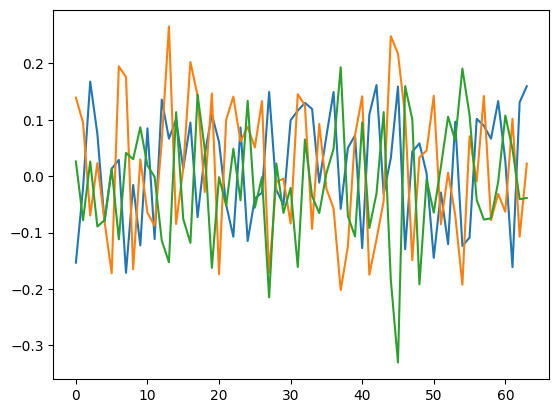

In [26]:
plt.plot(ood_features.mean(axis= 0))
plt.plot(features[labels == 0].mean(axis = 0))
plt.plot(features[labels == 1].mean(axis = 0))

In [42]:
features[labels == 2].var(axis = 0)

array([0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.01, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [28]:
a = features[labels == 0].mean(axis = 0)
b = features[labels == 1].mean(axis = 0)
c = features[labels == 2].mean(axis = 0)

In [43]:
def getCosineDistance(a,b):
    dot_product = a@b
    mag_a ,mag_b = np.linalg.norm(a),np.linalg.norm(b)
    cosine_angle = dot_product / (mag_a * mag_b)
    return cosine_angle
    angle_radians = np.arccos(cosine_angle)

    # Convert the angle to degrees
    angle_degrees = np.degrees(angle_radians)
    print(angle_degrees)

def getEuclideanDistance(a,b):
    return np.sqrt(((a-b)**2).sum())

In [45]:
getEuclideanDistance(a,)

1.3673266917916358

In [37]:
getCosineDistance(c,ood_features.mean(axis= 0))

0.9667138951525677

In [19]:
a = torch.rand(10,8)
b = torch.rand(1,8)

In [20]:
(a - b).pow(2).sum(dim= -1).sqrt().mean()

tensor(1.0539)

In [54]:
class Generator(nn.Module):
    def __init__(self,input_dim,feature_dim) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.linear = nn.Sequential(nn.Linear(input_dim,input_dim*2),nn.LeakyReLU(),
                                    nn.Linear(input_dim*2,input_dim*4),nn.LeakyReLU(),nn.Linear(input_dim*4,input_dim*8),nn.LeakyReLU(),
                                    nn.Linear(input_dim*8,input_dim*8),nn.LeakyReLU(), nn.Linear(input_dim*8,feature_dim)
                                    )
        
    
    def forward(self,X):
        out = self.linear(X)
        return out/torch.linalg.norm(out,dim= -1,keepdim= True)

In [55]:
#train_dataset = FreqWaveDataset(num_timesteps= 25,dataset_length= 10000,ts_dim= 1)
#test_dataset = FreqWaveDataset(num_timesteps= 25,dataset_length= 100,ts_dim= 1)
logger = Logger(name= "GAN",verbose= True)
logger.default_step_size = 1000

In [64]:
class OODMeanTrainer:
    def __init__(self,feature_generator : LSTMFeatureExtractor,classifier : nn.Module, generator: Generator, logger: Logger,cut_off,device: str):
        self.generator = generator.to(device)
        self.classifier = classifier.to(device)
        self.logger = logger
        self.feature_generator = feature_generator.to(device)
        self.device = device
        self.logger.setMetricReportSteps(metric_name= "ood_score", step_size= 1)
        self.cross_entropy_loss = nn.CrossEntropyLoss()
        self.mse_loss = nn.MSELoss()
        self.really_small_number = 1e-6
        self.cut_off = cut_off

    def plotGeneratedSample(self,z):
        for _ in range(3):
            with torch.no_grad():
                self.generator.eval()
                generated = self.generator(z)
                self.generator.train()
                plt.plot(generated.cpu().numpy()[0])
                plt.show()


    def calcDistanceLoss(self,batch,vector):
        """
        batch is of shape (BS,feature_dim)
        vector is of shape (1,feature_dim) or (BS,feature_dim)
        """
        distance = (batch - vector).pow(2).sum(dim= -1).sqrt()
        #distance = torch.clamp(distance,max= self.cut_off)
        return distance.mean()
    
    def trainGenerator(self,Z,means,generator_optimizer):
        """
        To train to generate points with max distance from the mean that still classifies as the mean
        """
        fake_features = self.generator(Z)
        selected_means = []
        self.classifier.eval()
        with torch.no_grad():
            classifier_predictions = torch.argmax(self.classifier(fake_features),dim= -1)  # take probablity of the original classes only
        #print(pd.Series(classifier_predictions.cpu().numpy()).value_counts())
        for pred_index in classifier_predictions:
            selected_means.append(means[pred_index])
        selected_means = torch.stack(selected_means,dim= 0).to(self.device)

        self.classifier.train()
        distance_loss = self.calcDistanceLoss(batch= fake_features,vector= selected_means)


        classifier_probs = self.classifier(fake_features) # taking the prob of unknown class
        targets = classifier_predictions#(torch.ones(classifier_probs.shape[0])).long().to(self.device)*(classifier_probs.shape[1] -1)
        log_generator_loss =  self.cross_entropy_loss(classifier_probs,targets)
        generator_optimizer.zero_grad()
        generator_loss = -distance_loss + log_generator_loss
        generator_loss.backward()
        generator_optimizer.step()
        self.logger.addMetric(metric_name= "log_generator_loss", value= log_generator_loss.cpu().item())
        self.logger.addMetric(metric_name= "generator_distance_loss", value= distance_loss.cpu().item())

    def trainStep(self,step,n_critic,batch,means,classifier_optimizer,generator_optimizer):
        """
        means is of shape (num_means,feature_dim)
        """
        batch_X,batch_y = batch["data"].float().to(self.device), batch["label"].to(self.device)
        #with torch.no_grad():
        #    Z = self.generateRandomZ(means = means,batch_size= batch_X.shape[0],seq_len= None).to(self.device)
        #self.trainClassifier(batch= batch_X,labels= batch_y,classifier_optimizer= classifier_optimizer,Z=Z)

        if step%n_critic == 0:
            batch_size,seq_len = batch_X.shape[0],means.shape[1]
            Z = self.generateRandomZ(means = means,batch_size= batch_X.shape[0]).to(self.device)
            self.trainGenerator(Z= Z,means= means,generator_optimizer=generator_optimizer)

        
    def trainClassifier(self,batch,labels,classifier_optimizer,Z):
        self.feature_generator.eval()
        with torch.no_grad():
            batch = self.feature_generator(batch)

        self.classifier.train()
        classifier_optimizer.zero_grad()
        model_out = self.classifier(batch)
        loss = self.cross_entropy_loss(model_out,labels)
        loss.backward()
        classifier_optimizer.step()
        self.logger.addMetric(metric_name= "classifier loss", value= loss.cpu().item())

        with torch.no_grad():
            fake_features = self.generator(Z)
        classifier_probs = F.softmax(self.classifier(fake_features.detach()),dim= -1)[:,-1] # taking the prob of unknown class
        log_classifier_loss = -torch.log(classifier_probs + self.really_small_number).mean()   # i want this to be 1,so fake batch is classified as fake
        classifier_optimizer.zero_grad()
        log_classifier_loss.backward()
        classifier_optimizer.step()
        self.logger.addMetric(metric_name= "log_classifier_loss", value= log_classifier_loss.item())


        
        
    
    def testOODDataset(self,ood_dataset):

        self.classifier.eval()
        self.feature_generator.eval()
        results = []
        loader = DataLoader(ood_dataset,batch_size= 32)
        with torch.no_grad():
            for batch in loader:
                result = self.classifier(self.feature_generator(batch["data"].float().to(self.device)))
                result = F.softmax(result,dim= -1)[:,-1].cpu().numpy().tolist()
                results.extend(result)
        results = np.array(results)
        self.classifier.train()
        self.feature_generator.train()
        self.logger.addMetric(metric_name= "ood_score", value= results.mean())


    def generateRandomZ(self,batch_size,means):
        #return torch.randn(batch_size,seq_len,self.generator.random_dim)
        #index = torch.randint(low= 0,high= means.shape[0],size=(batch_size,1) )[:,0]
        #Z = means[index]
        #Z += .1*torch.randn_like(Z)
        return torch.randn(batch_size,self.generator.input_dim)
    def getFeatureMeans(self,train_dataset):
        features= []
        labels = []
        loader = DataLoader(train_dataset,batch_size=64)
        self.feature_generator.eval()
        with torch.no_grad():
            for batch in loader:
                batch_out = self.feature_generator(batch["data"].float().to(self.device)).cpu().numpy().tolist()
                batch_labels = batch["label"].numpy().tolist()
                labels.extend(batch_labels)
                features.extend(batch_out)

        self.feature_generator.train()
        features = np.array(features)
        labels = np.array(labels)

        unique_labels = np.unique(labels).tolist()
        unique_labels.sort() # important
        means = []

        for unique_label in unique_labels:
            means.append(features[labels == unique_label].mean(axis =0))
        
        return torch.tensor(np.array(means)).float().to(self.device)




    def train(self,train_dataset,test_dataset,ood_dataset,epochs,batch_size,n_critic,gp_weight = .1,lr_classifier = 1e-4,lr_generator = 1e-5):
        train_dataloader = DataLoader(dataset= train_dataset,batch_size= batch_size,drop_last= True,shuffle= True)
        generator_optimizer = torch.optim.RMSprop(params= self.generator.parameters(), lr= lr_generator)
        classifier_optimizer = torch.optim.Adam(params= self.classifier.parameters(),lr= lr_classifier)
        means = self.getFeatureMeans(train_dataset= train_dataset)
        testing_sample = self.generateRandomZ(means = means,batch_size= 1).to(self.device)
        

        step = 0
        for epoch in range(epochs):
            for batch in train_dataloader:
                step += 1
                self.trainStep(step= step,n_critic= n_critic,batch=batch,means= means,
                               classifier_optimizer= classifier_optimizer,generator_optimizer=generator_optimizer)

                    
                if step%2500 == 0:
                    self.testOODDataset(ood_dataset= ood_dataset)
                    train_f1 = evaluateModelOnDataSetFeature(dataset= train_dataset,feature_extractor= self.feature_generator,classifier= self.classifier,device= self.device)
                    self.logger.addMetric(metric_name= "train_f1", value= train_f1)
                    test_f1 = evaluateModelOnDataSetFeature(dataset= test_dataset,device= self.device, classifier= self.classifier, feature_extractor= self.feature_generator)
                    self.logger.addMetric(metric_name= "test_f1", value= test_f1)
                    self.plotGeneratedSample(testing_sample)

In [68]:
generator = Generator(input_dim=8,feature_dim= 64)#LinearPredictor(feature_dim= 64,num_classes= 64)#TransformerFeatureGenerator(random_dim= 1,embedding_dim= 32,num_heads= 4, num_layers= 4,device= device)
discriminator = LinearPredictor(feature_dim= 64,num_classes= 1)
classifier = LinearPredictor(feature_dim= 64,num_classes= 3 + 1)
logger = Logger(name= "mean")

In [69]:
trainer = OODMeanTrainer(feature_generator= feature_extractor,classifier= classifier,generator= generator,logger= logger,cut_off= 2.5,device= device)

mean ---- 100 metric log_generator_loss = 1.3170108258724214
mean ---- 100 metric generator_distance_loss = 1.815151025056839
mean ---- 200 metric log_generator_loss = 1.3170054209232331
mean ---- 200 metric generator_distance_loss = 1.8244725286960601
mean ---- 300 metric log_generator_loss = 1.3170055067539215
mean ---- 300 metric generator_distance_loss = 1.8245263516902923
mean ---- 400 metric log_generator_loss = 1.3170066010951995
mean ---- 400 metric generator_distance_loss = 1.8245424008369446
mean ---- 500 metric log_generator_loss = 1.3170063555240632
mean ---- 500 metric generator_distance_loss = 1.8245715880393982
mean ---- 600 metric log_generator_loss = 1.3170069086551666
mean ---- 600 metric generator_distance_loss = 1.824576553106308
mean ---- 700 metric log_generator_loss = 1.3170063507556915
mean ---- 700 metric generator_distance_loss = 1.8245923447608947
mean ---- 800 metric log_generator_loss = 1.31700519323349
mean ---- 800 metric generator_distance_loss = 1.82460

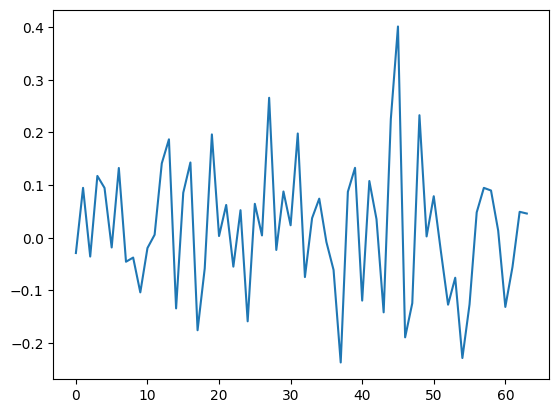

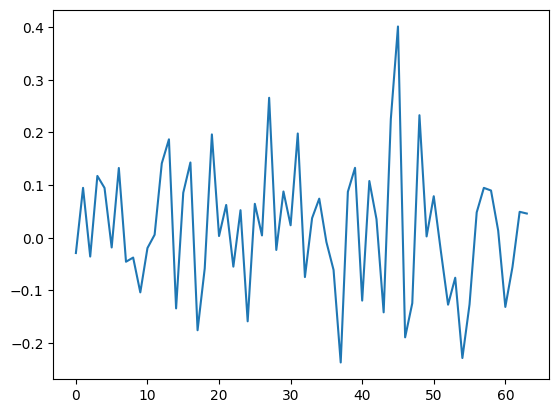

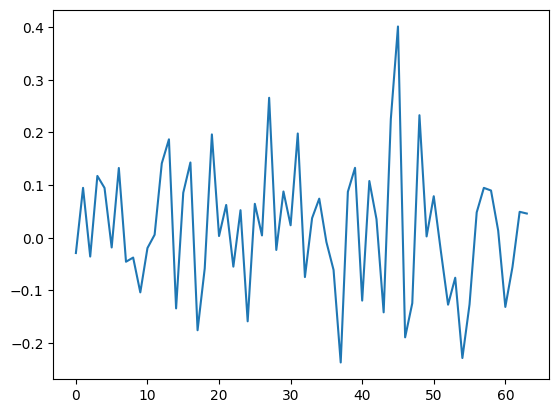

mean ---- 2600 metric log_generator_loss = 1.3170029056072234
mean ---- 2600 metric generator_distance_loss = 1.8246622586250305
mean ---- 2700 metric log_generator_loss = 1.3170029723644257
mean ---- 2700 metric generator_distance_loss = 1.8246631920337677
mean ---- 2800 metric log_generator_loss = 1.31700293302536
mean ---- 2800 metric generator_distance_loss = 1.8246632409095764
mean ---- 2900 metric log_generator_loss = 1.317002158164978
mean ---- 2900 metric generator_distance_loss = 1.824664216041565
mean ---- 3000 metric log_generator_loss = 1.3170025777816772
mean ---- 3000 metric generator_distance_loss = 1.8246654760837555
mean ---- 3100 metric log_generator_loss = 1.3170021784305572
mean ---- 3100 metric generator_distance_loss = 1.824665982723236
mean ---- 3200 metric log_generator_loss = 1.3170034182071686
mean ---- 3200 metric generator_distance_loss = 1.8246668243408204
mean ---- 3300 metric log_generator_loss = 1.317003264427185
mean ---- 3300 metric generator_distance_

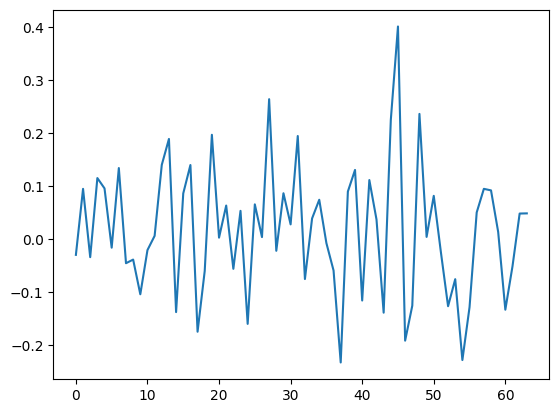

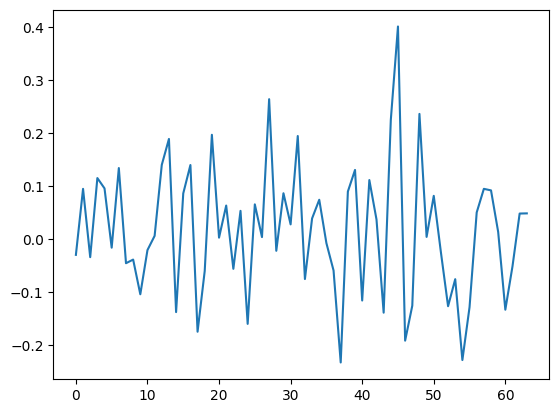

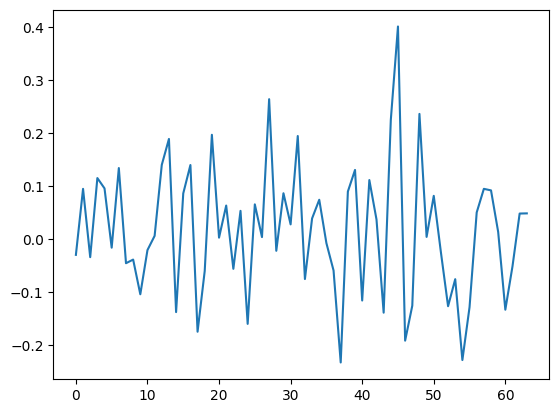

mean ---- 5100 metric log_generator_loss = 1.317002433538437
mean ---- 5100 metric generator_distance_loss = 1.82467449426651
mean ---- 5200 metric log_generator_loss = 1.3170023572444916
mean ---- 5200 metric generator_distance_loss = 1.82467435836792
mean ---- 5300 metric log_generator_loss = 1.3170024847984314
mean ---- 5300 metric generator_distance_loss = 1.8246750366687774
mean ---- 5400 metric log_generator_loss = 1.3170025169849395
mean ---- 5400 metric generator_distance_loss = 1.8246752154827117
mean ---- 5500 metric log_generator_loss = 1.3170022833347321
mean ---- 5500 metric generator_distance_loss = 1.8246749866008758
mean ---- 5600 metric log_generator_loss = 1.3170025002956391
mean ---- 5600 metric generator_distance_loss = 1.8246752190589905
mean ---- 5700 metric log_generator_loss = 1.3170018517971038
mean ---- 5700 metric generator_distance_loss = 1.8246755492687226
mean ---- 5800 metric log_generator_loss = 1.3170024001598357
mean ---- 5800 metric generator_distance

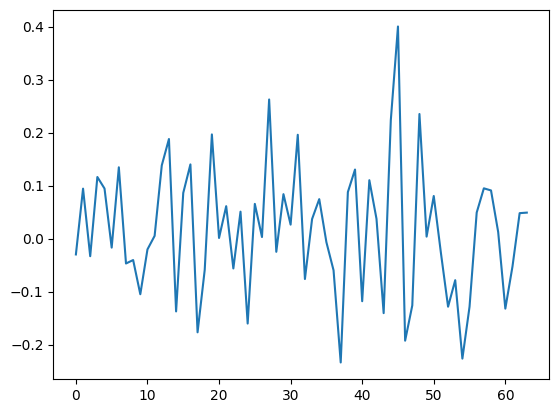

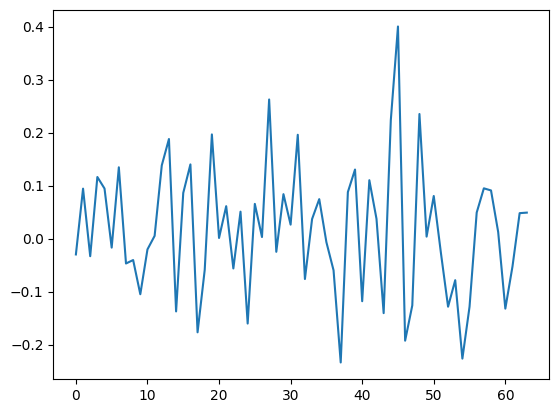

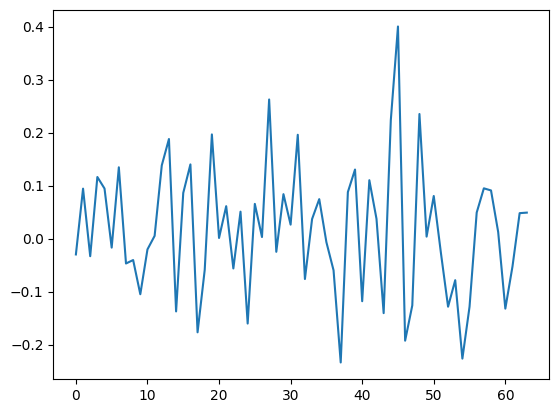

mean ---- 7600 metric log_generator_loss = 1.3170011556148529
mean ---- 7600 metric generator_distance_loss = 1.824677916765213
mean ---- 7700 metric log_generator_loss = 1.3170010352134705
mean ---- 7700 metric generator_distance_loss = 1.8246779453754425
mean ---- 7800 metric log_generator_loss = 1.3170018255710603
mean ---- 7800 metric generator_distance_loss = 1.8246782946586608
mean ---- 7900 metric log_generator_loss = 1.317001575231552
mean ---- 7900 metric generator_distance_loss = 1.824678245782852
mean ---- 8000 metric log_generator_loss = 1.3170013558864593
mean ---- 8000 metric generator_distance_loss = 1.8246782517433167
mean ---- 8100 metric log_generator_loss = 1.3170014584064484
mean ---- 8100 metric generator_distance_loss = 1.8246787190437317
mean ---- 8200 metric log_generator_loss = 1.3170015048980712
mean ---- 8200 metric generator_distance_loss = 1.8246786725521087
mean ---- 8300 metric log_generator_loss = 1.3170014643669128
mean ---- 8300 metric generator_distan

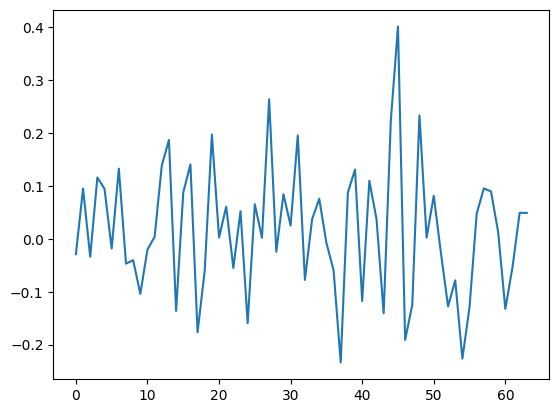

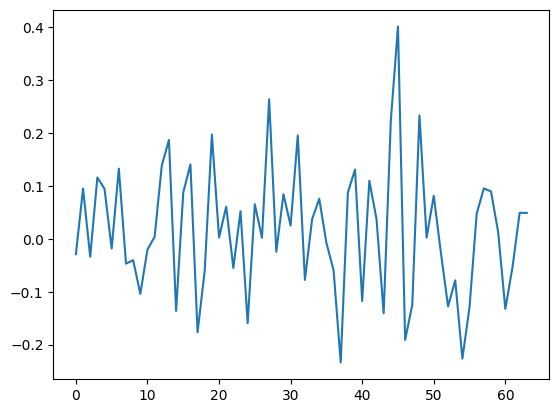

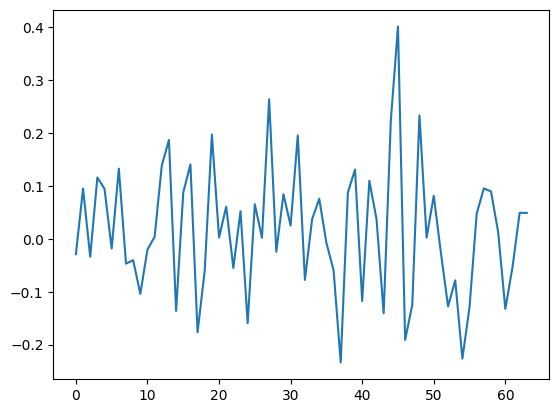

mean ---- 10100 metric log_generator_loss = 1.3170014095306397
mean ---- 10100 metric generator_distance_loss = 1.8246798896789551
mean ---- 10200 metric log_generator_loss = 1.317001346349716
mean ---- 10200 metric generator_distance_loss = 1.8246800768375397
mean ---- 10300 metric log_generator_loss = 1.3170013308525086
mean ---- 10300 metric generator_distance_loss = 1.8246800923347473
mean ---- 10400 metric log_generator_loss = 1.3170013284683229
mean ---- 10400 metric generator_distance_loss = 1.82468017578125
mean ---- 10500 metric log_generator_loss = 1.3170012819766999
mean ---- 10500 metric generator_distance_loss = 1.8246801006793976
mean ---- 10600 metric log_generator_loss = 1.3170012879371642
mean ---- 10600 metric generator_distance_loss = 1.8246802473068238
mean ---- 10700 metric log_generator_loss = 1.3170013582706452
mean ---- 10700 metric generator_distance_loss = 1.8246804523468017
mean ---- 10800 metric log_generator_loss = 1.3170012891292573
mean ---- 10800 metric 

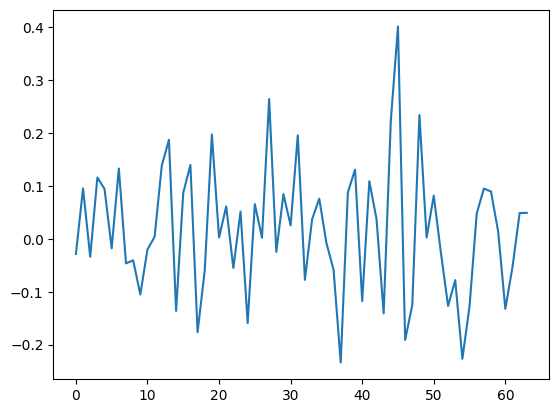

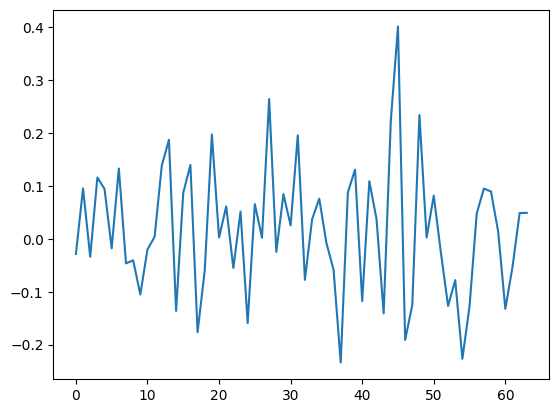

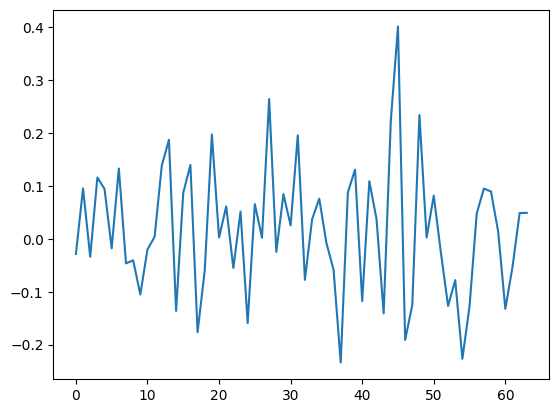

mean ---- 12600 metric log_generator_loss = 1.3170010554790497
mean ---- 12600 metric generator_distance_loss = 1.82468106508255
mean ---- 12700 metric log_generator_loss = 1.3170010256767273
mean ---- 12700 metric generator_distance_loss = 1.8246811437606811
mean ---- 12800 metric log_generator_loss = 1.317000983953476
mean ---- 12800 metric generator_distance_loss = 1.8246810781955718
mean ---- 12900 metric log_generator_loss = 1.3170010185241698
mean ---- 12900 metric generator_distance_loss = 1.8246811842918396
mean ---- 13000 metric log_generator_loss = 1.317000982761383
mean ---- 13000 metric generator_distance_loss = 1.8246812736988067
mean ---- 13100 metric log_generator_loss = 1.3170008671283722
mean ---- 13100 metric generator_distance_loss = 1.8246808397769927


KeyboardInterrupt: 

: 

In [70]:
trainer.train(train_dataset= train_dataset,test_dataset= test_dataset,ood_dataset= ood_dataset,epochs= 300,batch_size= 128,n_critic= 1,lr_generator= .001)  

In [119]:
means = trainer.getFeatureMeans(train_dataset= train_dataset).cpu()

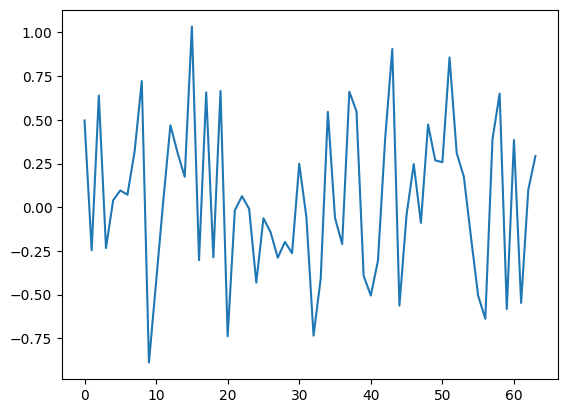

In [125]:
plt.plot(trainer.generateRandomZ(batch_size= 1, seq_len= 64,means =means).cpu().numpy()[0])
#plt.plot(means[0])
#plt.plot(means[1])
#plt.plot(means[2])

In [ ]:
ood_loader = DataLoader(dataset=ood_dataset,batch_size= 32)
trainer.classifier.eval()
trainer.feature_generator.eval()
results = []
with torch.no_grad():
    for batch in ood_loader:
        result = trainer.classifier(trainer.feature_generator(batch["data"].float().to(device)))
        result = F.softmax(result,dim= -1)
        results.extend(result.cpu().numpy().tolist())

results = np.array(results)

In [ ]:
results

array([[1.78e-02, 2.09e-02, 9.61e-01, 1.28e-04],
       [2.05e-02, 1.47e-02, 9.65e-01, 8.78e-05],
       [2.25e-02, 1.31e-02, 9.64e-01, 8.10e-05],
       ...,
       [3.11e-02, 6.79e-01, 2.90e-01, 7.69e-07],
       [6.28e-02, 1.33e-01, 8.04e-01, 6.41e-06],
       [2.48e-02, 7.21e-01, 2.54e-01, 5.53e-07]])

In [ ]:
real_dataset = []
real_dataset_labels = []
loader = DataLoader(train_dataset,batch_size= 64)
with torch.no_grad():
    for batch in loader:
        res = feature_extractor(batch["data"].float().to(device)).cpu().numpy().tolist()
        real_dataset_labels.extend(batch["label"].cpu().numpy().tolist())
        real_dataset.extend(res)
    
        


real_dataset = np.array(real_dataset)

1    3495
2    3180
0    3100
Name: count, dtype: int64

0 1


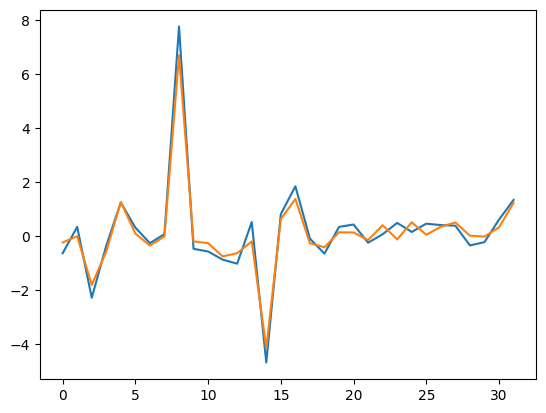

In [ ]:
print(real_dataset_labels[0], real_dataset_labels[300])
plt.plot(real_dataset[0])
plt.plot(real_dataset[300])

In [ ]:
fake_dataset = []
for index in range(trainer.n):
    #index = -1
    with torch.no_grad():
        trainer.generators[index].eval()
        for _ in range(100):
            data = trainer.generators[index](trainer.generateRandomZ(batch_size= 32,seq_len= 32).to(device))
            data = data.view(data.shape[0],-1).cpu().numpy().tolist()
            fake_dataset.extend(data)
fake_dataset = np.array(fake_dataset)

In [ ]:
from sklearn.manifold import TSNE

pca = PCA(n_components=30)  # Choose number of principal components
pca_real_data = real_dataset#pca.fit_transform(real_dataset)

# Fit t-SNE on PCA-transformed real data
tsne = TSNE(n_components=2, random_state=42)
tsne_real_data = tsne.fit_transform(pca_real_data)

# Transform fake data using the learned PCA and t-SNE transformations
pca_fake_data = fake_dataset#pca.transform(fake_dataset)
tsne_fake_data = tsne.fit_transform(pca_fake_data)

# Plot t-SNE of PCA-transformed real and fake data
plt.scatter(tsne_real_data[:, 0], tsne_real_data[:, 1], label='Real Data (PCA+t-SNE)', c='blue', alpha=0.5)
plt.scatter(tsne_fake_data[:, 0], tsne_fake_data[:, 1], label='Fake Data (PCA+t-SNE)', c='red', alpha=0.1)

# Add labels and legend
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Plot of PCA-Transformed Real and Fake Data')
plt.legend()


AttributeError: 'list' object has no attribute 'shape'

In [ ]:
ood_dataset = FreqWaveDataset(ts_dim= 1,dataset_length= 1000,freq_ranges= [(1,.4)], num_timesteps= 25)

In [ ]:
def testOOD(classifier : LSTMClassifier,discriminator : CNNDiscriminator, ood_dataset : FreqWaveDataset):

    loader = DataLoader(ood_dataset,batch_size= 32)
    classifier = classifier.to(device).eval()
    discriminator = discriminator.to(device).eval()
    total_ood = 0
    count = 0
    dis_scores = []
    with torch.no_grad():
        for batch in loader:
            X = batch["data"].float().to(device)
            #X = torch.randn_like(X).to(device)
            preds = torch.argmax(classifier(X),dim= -1)
            ood = (preds == 2).sum()
            total_ood += ood

            scores = discriminator(X)
            dis_scores.extend(scores.cpu().numpy()[:,0].tolist())

            count += X.shape[0]
    print(total_ood/count)
    return np.array(dis_scores)


In [ ]:
scores = testOOD(classifier=classifier,discriminator= trainer.super_discriminator,ood_dataset= ood_dataset)

tensor(0.7231, device='cuda:0')


In [ ]:
# for 2 to 3
print()
print(pd.Series(scores).describe())


count    325.000000
mean      -2.748871
std        0.681535
min       -4.433862
25%       -3.247192
50%       -2.865038
75%       -2.233341
max       -1.142857
dtype: float64


(array([ 7.,  6., 35., 61., 61., 47., 35., 44., 21.,  8.]),
 array([-4.43, -4.1 , -3.78, -3.45, -3.12, -2.79, -2.46, -2.13, -1.8 ,
        -1.47, -1.14]),
 <BarContainer object of 10 artists>)

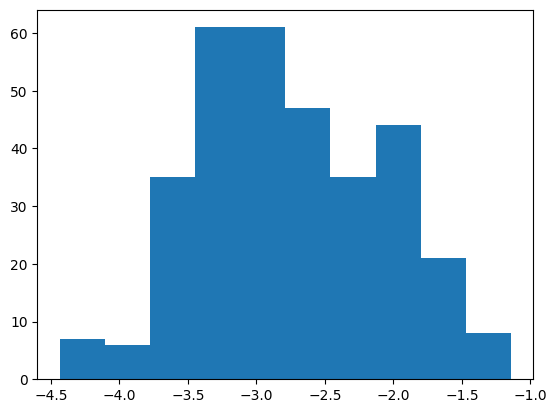

In [ ]:
plt.hist(scores)

In [ ]:
# train dataset .1735
# ood dataset .1851

In [ ]:
# batch replacement
# train_dataset .0757
# ood dataset .6308

In [ ]:
a = torch.tensor([10,11]).float()
print(F.softmax(a,dim= -1))
(-F.softmax(a,dim = -1)*F.log_softmax(a,dim= -1)).sum()

tensor([0.2689, 0.7311])


tensor(0.5822)

In [ ]:
loader = DataLoader(train_dataset,batch_size = 10)

In [ ]:
for i in loader:
    break

In [ ]:
discriminator(torch.randn(5,25,1).to(device))

tensor([[0.0272],
        [0.0333],
        [0.0429],
        [0.0414],
        [0.0500]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
discriminator(i["data"].float().to(device))

tensor([[ 0.0299],
        [ 0.0088],
        [ 0.0458],
        [ 0.0022],
        [ 0.0347],
        [ 0.0435],
        [-0.0004],
        [ 0.0039],
        [ 0.0207],
        [ 0.0280]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
torch.argmax(F.softmax(classifier(torch.rand_like(i["data"]).float().to(device)),dim= -1),dim= -1).cpu().detach().numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [ ]:
torch.argmax(F.softmax(classifier(i["data"].float().to(device)),dim= -1),dim= -1)

tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')

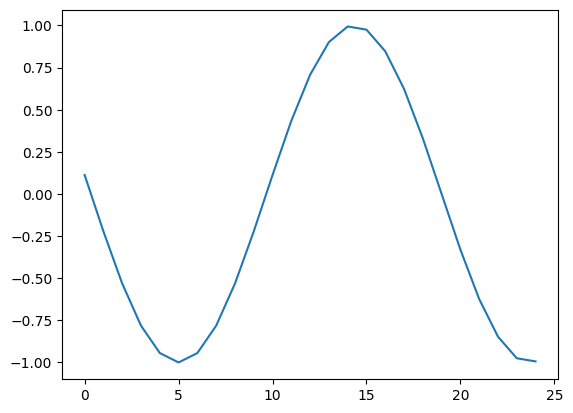

In [ ]:
plt.plot(train_dataset[np.random.randint(len(train_dataset))]["data"][:,0])

tensor([[-3.6968]], device='cuda:0')
tensor([[6.2416e-09, 7.7776e-08, 1.0000e+00]], device='cuda:0')


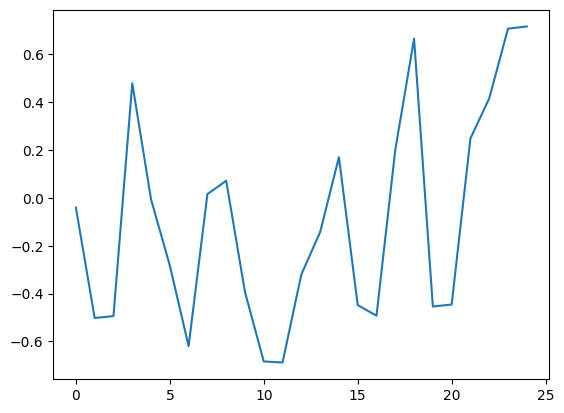

In [ ]:
with torch.no_grad():
    generator = trainer.generators[-1]
    generator.eval()
    generated = generator.to(device)(trainer.generateRandomZ(batch_size= 1,seq_len= 25))
    #generated = generator.to(device)(torch.tensor(np.random.normal(loc= 1,scale= 1,size= (1,25,16))).float().to(device))
    print(discriminator(generated))
    print(F.softmax(classifier(generated),dim= -1))
    generated = generated[0,:,0].cpu()
plt.plot(generated)

In [ ]:
print(generated)

tensor([0.0032, 0.0018, 0.0019, 0.0033, 0.0039, 0.0013, 0.0026, 0.0017, 0.0032,
        0.0031])


In [ ]:
freq_ranges = ((.1,.5),(1,1.4))
timestamps = np.arange(25)
sampled_freq, sampled_phase = .8,0
wave = np.sin(timestamps*sampled_freq + sampled_phase)

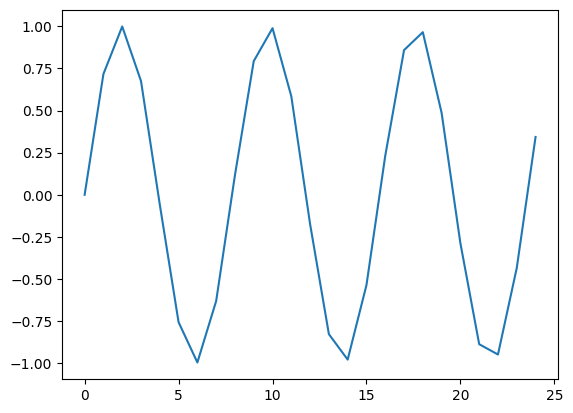

In [ ]:
plt.plot(wave)

In [ ]:
F.softmax(classifier(torch.tensor(wave).float().to(device).unsqueeze(0).unsqueeze(-1)),dim= -1)

tensor([[0.3845, 0.6155]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

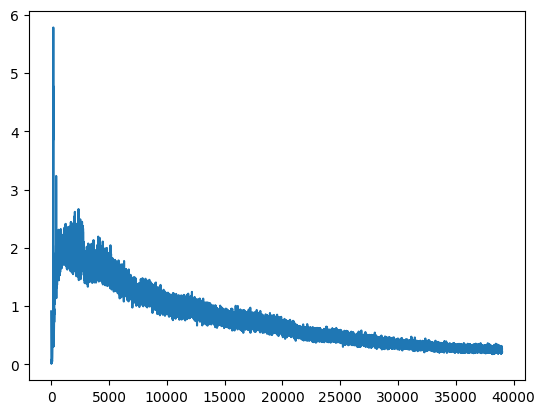

In [ ]:
plt.plot(logger.getMetric("gp_loss"))

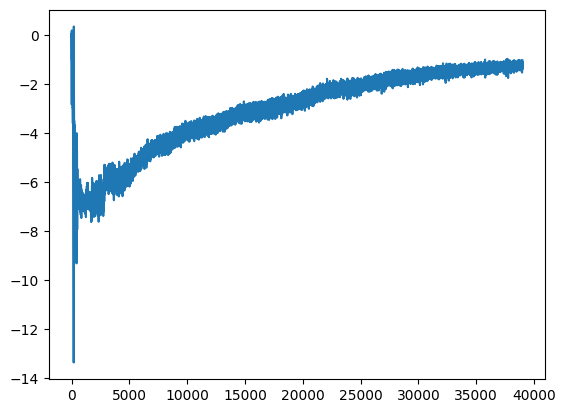

In [ ]:
plt.plot(logger.getMetric("cost_wd"))

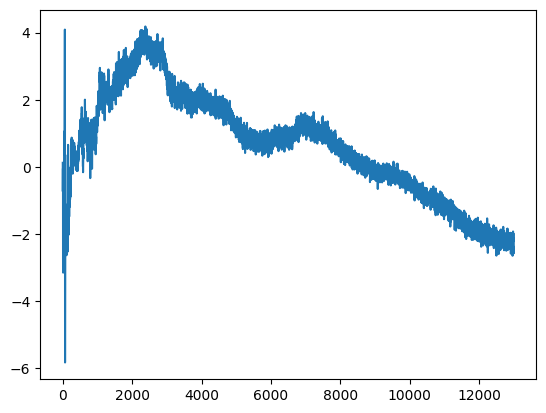

In [ ]:
plt.plot(logger.getMetric("generator_loss"))

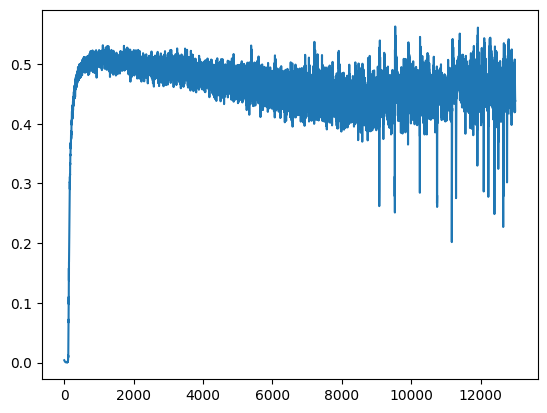

In [ ]:
plt.plot(logger.getMetric("generator kl loss"))

In [ ]:
predicted = []
labels = []
with torch.no_grad():
    for batch in DataLoader(train_dataset,batch_size= 32):
        X,y = batch["data"], batch["label"]
        y_pred = torch.argmax(classifier(X.to(device).float()),dim= -1).cpu().numpy().tolist()

        predicted.extend(y_pred)
        labels.extend(y.cpu().numpy().tolist())

        

In [ ]:
predicted = np.array(predicted)
labels = np.array(labels)

In [ ]:
(predicted == labels).sum()

5000